In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import rdflib as rdf

In [27]:
dir = "Train/"
train_data = []
img_size = 32
non_chars = ["#","$","&","@", '1', '2', '3', '4', '5', '6', '7', '8', '9']
for i in os.listdir(dir):
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        if i == '0':
            train_data.append([img,'O'])
        else:
            train_data.append([img,i])

KeyboardInterrupt: 

In [3]:
len(train_data)

361622

In [2]:
val_dir = "Validation/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        if i == '0':
            val_data.append([img,'O'])
        else:
            val_data.append([img,i])

In [5]:
len(val_data)

7019

In [6]:
random.shuffle(train_data)
random.shuffle(val_data)

NameError: name 'train_data' is not defined

In [7]:
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [30]:
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [9]:
textfile = open("train_Y.txt", "w")
for element in train_Y:
    textfile.write(element + "\n")
textfile.close()

textfile = open("val_Y.txt", "w")
for element in val_Y:
    textfile.write(element + "\n")
textfile.close()

In [10]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

In [11]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [32]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [13]:
print(train_X.shape,val_X.shape)

(361622, 32, 32, 1) (7019, 32, 32, 1)


In [33]:
print(train_Y.shape,val_Y.shape)

NameError: name 'train_Y' is not defined

In [3]:
graph = rdf.Graph()
knowledge_source = graph.parse(file=open("KB.n3", "r"), format="text/n3")


BadSyntax: at line 7 of <>:
Bad syntax (objectList expected) at ^ in:
"...b'-syntax-ns#>.\n\nind:hyp0 a class:Hyperparameter;\n\t\trdfs:label'^b' batch_size;\n\t\trdfs:Literal 64.\n\nind:hyp1 a class:Hyperparam'..."

In [ ]:
def query_result(label):
    result = graph.query(f"""SELECT ?value
       WHERE {{
          ?ind rdfs:label {label}.
          ?ind rdf:value ?value.
       }}""")
    return label_result(result)

In [ ]:
def label_result(result):
    for row in result:
        data = int(row.asdict()['value'])
    return data

In [ ]:
batch_size = query_result('\'batch_size\'')
epochs = query_result('\'epochs\'')
CNN_kernel_size = query_result('\'CNN_kernel_size\'')
MaxPooling_kernel_size = query_result('\'MaxPooling_kernel_size\'')

In [15]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(CNN_kernel_size, CNN_kernel_size),activation='linear',padding='same',input_shape=(32,32,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((MaxPooling_kernel_size, MaxPooling_kernel_size),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (CNN_kernel_size, CNN_kernel_size), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(MaxPooling_kernel_size, MaxPooling_kernel_size),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (CNN_kernel_size, CNN_kernel_size), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(MaxPooling_kernel_size, MaxPooling_kernel_size),padding='same'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))           
model.add(Dropout(0.3))
model.add(Dense(26, activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [17]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [18]:
history = model.fit(train_X, train_Y, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(val_X, val_Y))

Epoch 1/6
11301/11301 [==============================] - 612s 54ms/step - loss: 0.2975 - accuracy: 0.9057 - val_loss: 0.2582 - val_accuracy: 0.9031
Epoch 2/6
11301/11301 [==============================] - 591s 52ms/step - loss: 0.1836 - accuracy: 0.9399 - val_loss: 0.2206 - val_accuracy: 0.9191
Epoch 3/6
11301/11301 [==============================] - 602s 53ms/step - loss: 0.1670 - accuracy: 0.9441 - val_loss: 0.1826 - val_accuracy: 0.9330
Epoch 4/6
11301/11301 [==============================] - 572s 51ms/step - loss: 0.1571 - accuracy: 0.9471 - val_loss: 0.1893 - val_accuracy: 0.9342
Epoch 5/6
11301/11301 [==============================] - 516s 46ms/step - loss: 0.1513 - accuracy: 0.9484 - val_loss: 0.1882 - val_accuracy: 0.9263
Epoch 6/6
11301/11301 [==============================] - 513s 45ms/step - loss: 0.1466 - accuracy: 0.9495 - val_loss: 0.1813 - val_accuracy: 0.9347


In [34]:
model.save('model.h5')

In [ ]:
def kb_update(label, value, old_value):
    result = graph.update(f"""DELETE {{?ind rdf:value {old_value}}}
       INSERT {{?ind rdf:value {value}}}
       WHERE {{
          ?ind rdfs:label '{label}'
       }}""")
    knowledge_source.serialize(destination="KB.n3")
    return print(f'{label} value updated!')

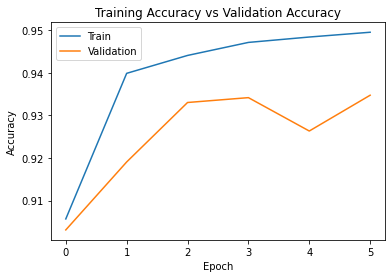

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

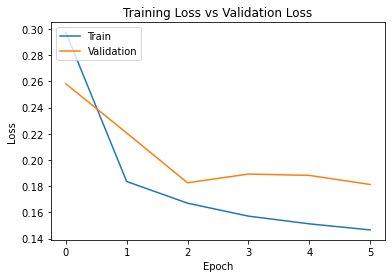

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()